Load Libraries

In [1]:
import os
import time
import faiss
import string
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from typing import List
from collections import Counter

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report,confusion_matrix

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

In [2]:
df=pd.read_csv("./data/20_newsgroup.csv")
df=df[["text","title"]]

In [3]:
df.sample(5)

,text,title
7017,\nGo-Video machines used in HQ2 mode will copy...,sci.electronics
4302,Are there any Workspace Managers out there for...,comp.os.ms-windows.misc
10670,"ri\n\n\n\nI do agree with you, in a way. The ...",talk.politics.misc
6865,I am making a search for a CAD program that do...,sci.electronics
3906,\n\tExcept for the fact that it's superior in ...,comp.sys.ibm.pc.hardware


In [4]:
df['title'].unique()

array(['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space',
       'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc',
       'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x',
       'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian',
       'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt'],
      dtype=object)

In [5]:
df["text"].iloc[1500]

'Hi, can anyone direct me to map type gifs? \n\nI am interesting in cartography and would find\nthese gifs useful.\n\ntia,\n'

## selecting few diverse classes for usecase

In [6]:
selected=df[df["title"].isin(['sci.space','comp.sys.mac.hardware','soc.religion.christian','comp.graphics','sci.med'])]

In [7]:
selected.drop_duplicates(inplace=True)

/var/folders/0w/7szmzlg15ljc6n0sn48w0jph0000gq/T/ipykernel_67686/1199455941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected.drop_duplicates(inplace=True)


In [8]:
selected_df=selected.groupby('title').sample(400)
selected_df["text"]=selected_df["text"].astype(str)

In [9]:
len(selected_df)

2000

In [10]:
selected_df[["text","title"]].sample(5)

,text,title
9356,LISTOWNER: I have sent this to Mr Anderson pri...,soc.religion.christian
1154,\n..\n\n\n\nHmmm... Sounds vaguely similar to ...,comp.sys.mac.hardware
2981,\n\n\nI recall that the issue is that fat on t...,sci.med
795,Does anyone work with the A/ROSE card?\n\nWe h...,comp.sys.mac.hardware
1699,"Hi,\n\nwell I have opened up a FTP site for ge...",comp.graphics


## Data Cleaning

In [11]:
import re

def clean(text):
    text=text.lower()
    url_removed=re.sub(r'https\S+','',text,flags=re.MULTILINE)
    text=re.sub("[^a-zA-Z]"," ",url_removed)
    text=re.sub("\.+"," ",text)
    text=[word for word in text if word not in string.punctuation]
    text="".join(text).strip()
    text=re.sub("\s\s+", " ", text)
    return "".join(text).strip()


selected_df["cleaned_data"]=selected_df["text"].apply(lambda x:clean(x) if x!=None else x)

## Split into train and test

In [12]:
train,test= train_test_split(selected_df,stratify=selected_df[["title"]],test_size=0.2)
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [13]:
train['title'].value_counts()

title
sci.med                   320
comp.graphics             320
sci.space                 320
comp.sys.mac.hardware     320
soc.religion.christian    320
Name: count, dtype: int64

## Save the data

In [14]:
train.to_csv("train_data.csv",index=False)
test.to_csv("test_data.csv",index=False)

## Generate Embedding using paralleism

In [15]:
model=SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
train_cleaned_texts = train["cleaned_data"].tolist()
train_cleaned_texts = list(map(str, train_cleaned_texts))
import time
import os

def get_embeddings(model, sentences: List[str], parallel: bool = True):
    start = time.time()
    if parallel:
        # Start the multi-process pool on all cores
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        pool = model.start_multi_process_pool(target_devices=["cpu"] * 5)
        embeddings = model.encode_multi_process(sentences, pool, batch_size=16)
        model.stop_multi_process_pool(pool)
    else:
        os.environ["TOKENIZERS_PARALLELISM"] = "true"
        embeddings = model.encode(
            sentences,
            batch_size=32,
            show_progress_bar=True,
            convert_to_tensor=True,
        )
    print(f"Time taken to encode {len(sentences)} items: {round(time.time() - start, 2)}")
    return embeddings.detach().numpy()

train_embeddings = get_embeddings(model=model, sentences=train_cleaned_texts, parallel=False)
print(train_embeddings.shape)

#save embeddings of idea texts
cleaned_train_texts_embeddings_file = f"./data/train_embeddings_all_minilm_l6_v2.pkl"
pickle.dump(train_embeddings, open(cleaned_train_texts_embeddings_file, "wb"))




Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Time taken to encode 1600 items: 68.82
(1600, 384)


## create mappings

In [16]:
#create mappings for index and category this will be later used for faiss
train_category_index_mapping=dict(zip(train.index,train.title))
with open('./data/train_category_index.pickle', 'wb') as handle:
    pickle.dump(train_category_index_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

#load the mappings file which is used for printing category as output
def get_mappings(file_name):
    with open(file_name, 'rb') as handle:
        category_mapping_dict = pickle.load(handle)
    return category_mapping_dict


mappings = get_mappings(file_name='./data/train_category_index.pickle')

# load embeddings 

In [17]:


#read the embeddings created at earlier step
def read_embeddings(file_name):
    cleaned_texts_embeddings_file = file_name
    if os.path.exists(cleaned_texts_embeddings_file):
        with open(cleaned_texts_embeddings_file, "rb") as f:
            embeddings = pickle.load(f)
    temp1=np.asarray(embeddings,dtype="float32")
    return temp1


    return

samples = read_embeddings(file_name=f"./data/train_embeddings_all_minilm_l6_v2.pkl")

## Creating and saving index

In [18]:


#save the index once its created
def save_index(index):
    path = os.path.join("./data/","news_train_index")
    faiss.write_index(index, path)

# we have used flat Index and with Inner product
def create_index(mappings,samples):
    index = faiss.IndexIDMap(faiss.IndexFlatIP(samples.shape[1]))
    faiss.normalize_L2(samples)  # normalise the embedding
    #index.train(samples)
    index.add_with_ids(samples,np.array(list(mappings.keys())))
    save_index(index)
create_index(mappings=mappings,samples=samples)

In [19]:
# print top 2 categories among top5 nearest neighbours returned from index search
train=pd.read_csv("train_data.csv") # using the file from previous notebook created step
test=pd.read_csv("test_data.csv")




## read the index and search for test query in index using predict function

In [20]:



#read the index
index = faiss.read_index("./data/news_train_index")

# embeddings for query
def predict_embeddings(query):
    query_embedding=model.encode(query)
    query_embedding=np.asarray([query_embedding],dtype="float32")
    return query_embedding
    

#predict for given query
def predict(query,mappings):
    cleaned_query= clean(query)
    query_embedding=predict_embeddings(cleaned_query)
    faiss.normalize_L2(query_embedding)
    D, I = index.search(query_embedding, 5) # d is the distance and I is the index number 
    res_df=[]
    for values in I:
        for val in D:
            details= {'cleaned_text':list(train.iloc[values]["cleaned_data"]),
            'category':list(train.iloc[values]["title"]),
            'score':list(val)
            }
            res_df.append(details)
    return res_df


## obtain most frequent class or final class

In [21]:

def most_frequent(result):
    top2 = Counter(result)
    return top2.most_common(1)

In [22]:
pd.set_option('display.max_rows', None)
res=predict("cad tools utilises graphics card  The quality of the image depends on the quality of the graphics card.",mappings=mappings)

In [23]:
 res=predict("glycemic index",mappings=mappings)

In [24]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.DataFrame(res[0])

,cleaned_text,category,score
0,a can anyone tell me if a bloodcount of when diagnosed as hypoglycemic is a dangerous i e indicates a possible pancreatic problem one dr says no the a other not his specialty says the first is negligent and that another blood a test should be done also what is a good diet what has worked for a hypo a glycemic tia a a a anthony anello a fermilab a batavia illinois once you have your hypoglycemia confirmed through the proper channels you might consider ther following chelated manganese mg day chelated chromium mcg day increase protein through foods or supplements avoid supplements foods high in potassium calcium zinc avoid vit c supplements in excess of mg avoid honey and foods high in simple sugars enjoy breads cereals grains discuss the above with your health practitioner for compatibility with your body chemistry and safety ron,sci.med,0.444681
1,are you sure g is the right number as far as i know pilots are blackout in dives that exceed g g g seems to be out of human tolerance would anybody clarify this please lan,sci.space,0.366020
2,it s worse than that there is no such thing as a double blind study on the effects of msg by virtue of the fact that msg changes the taste of food in a characteristic way that is detectable by the subject and that cannot be duplicated by a placebo common you can easily disguise to flavor of msg by putting it in a capsule then the study becomes a double blind of msg capsules against control capsules containing exactly the same contents minus the msg,sci.med,0.338126
3,my blood pressure soars my heart pounds and i can t get to sleep for the life of me feels about like i just drank cups of coffee i avoid it and beet sugar flavor enhancers beet powder and whatever other names it may go under basicaly i read the ingredients and if i don t know what they all are i don t buy the product msg sensitivity is definately real relativity schmelativity richard h clark my opinions are my own and lunatik watch for me on the road ought to be yours but under it s not my fault i voted perot no circumstances are they richard tis com those of my company,sci.med,0.335596
4,glutamate is not an essential amino acid people can survive quite well without ever eating any keith lynch kfl access digex com,sci.med,0.330145


## Test Data Prediction

In [25]:



def test_predict(query,mappings=mappings):
    cleaned_query= clean(query)
    query_embedding=predict_embeddings(cleaned_query)
    faiss.normalize_L2(query_embedding)
    D, I = index.search(query_embedding, 5) # d is the distance and I is the index number 
    return most_frequent([mappings[id_] for id_ in I[0]])[0][0]


test["predict"]=test["cleaned_data"].astype(str).apply(lambda x:test_predict(x))

# time taken for flat index

In [26]:
start=time.time()
print(test_predict("intel graphics card",mappings),time.time()-start)

comp.sys.mac.hardware 0.01577591896057129


# Evaluate flat index results

In [27]:
print(classification_report(test['title'],test["predict"]))
cm = confusion_matrix(test['title'],test["predict"])

                        precision    recall  f1-score   support

         comp.graphics       0.87      0.86      0.87        80
 comp.sys.mac.hardware       0.90      0.91      0.91        80
               sci.med       0.91      0.94      0.93        80
             sci.space       0.92      0.86      0.89        80
soc.religion.christian       0.95      0.99      0.97        80

              accuracy                           0.91       400
             macro avg       0.91      0.91      0.91       400
          weighted avg       0.91      0.91      0.91       400



<Axes: >

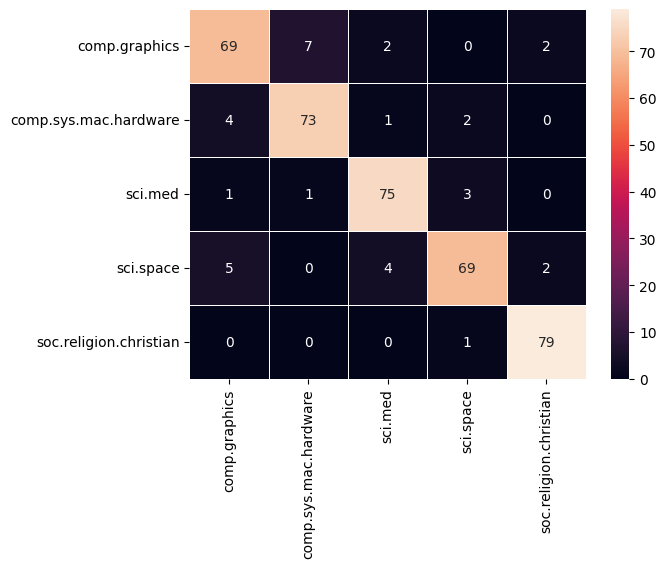

In [28]:

labels = ['comp.graphics','comp.sys.mac.hardware','sci.med','sci.space','soc.religion.christian']
sns.heatmap(cm, fmt='d', annot=True,
     # set all to white
            linewidths=0.5, linecolor='w',  # draw black grid lines
            xticklabels=labels,yticklabels=labels)                     # disable colorbar

# # re-enable outer spines
# sns.despine(left=False, right=False, top=False, bottom=False)

In [29]:
acc_score = accuracy_score(test['title'],test["predict"])
print("Test Accuracy Score",acc_score)

Test Accuracy Score 0.9125


# Experimenting with ivfflat index

In [30]:
# second index 


#save the index once its created
def save_index(index):
    path = os.path.join("./data/","news_ivf_flat")
    faiss.write_index(index, path)


nlist = 5  # number of clusters
dimension=384 # embeddings dimension

# we have used flat Index and with Inner product
def create_index_ivf(mappings,samples,nlist=nlist,dimension=dimension):
    quantiser = faiss.IndexFlatL2(dimension)  
    index = faiss.IndexIVFFlat(quantiser, dimension, nlist,   faiss.METRIC_L2)
    index.train(samples)
    index.add(samples)   # add the vectors and update the index
    print(index.is_trained)  # True
    print(index.ntotal)  
    index.add_with_ids(samples,np.array(list(mappings.keys())))
    save_index(index)
    return


create_index_ivf(mappings=mappings,samples=samples)

True
1600


# Reading and searching inside ivfflat index

In [31]:



#read the index
index = faiss.read_index("./data/news_ivf_flat")

# embeddings for query
def predict_embeddings(query):
    query_embedding=model.encode(query)
    query_embedding=np.asarray([query_embedding],dtype="float32")
    return query_embedding
    

#predict for given query
def predict(query,mappings):
    cleaned_query= clean(query)
    query_embedding=predict_embeddings(cleaned_query)
    faiss.normalize_L2(query_embedding)
    D, I = index.search(query_embedding, 5) # d is the distance and I is the index number 
    for values in I:
        for distance in D:
            details= {'cleaned_text':train.iloc[values]["cleaned_data"],
            'category':train.iloc[values]["title"],
            'score':distance
            }
            print("===============================================")
            print(pd.DataFrame(details))
            print("===============================================")
    return most_frequent([mappings[id_] for id_ in I[0]])

In [32]:
res=predict(query="'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.",mappings=mappings)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        cleaned_text  \
1465  there s this old se here it s got the older style fans that remind me of a house ventilator a cylindrical drum instead of the bladed rotor i usually see anyway the se makes this loud buzzing noise due to vibration somewheres if i remove the screws and loosen the front from the back it quiets down i can only assume that the fan housing from this goofy thing is touching the back of the case and vibrating against it anyway any suggestions for where to get r

In [33]:
def test_predict_ivf(query,mappings=mappings):
    cleaned_query= clean(query)
    query_embedding=predict_embeddings(cleaned_query)
    faiss.normalize_L2(query_embedding)
    D, I = index.search(query_embedding, 5) # d is the distance and I is the index number 
    return most_frequent([mappings[id_] for id_ in I[0]])[0][0]


test["predict_ivf"]=test["cleaned_data"].astype(str).apply(lambda x:test_predict_ivf(x))

## time taken for ivfflat

In [34]:
start=time.time()
print(test_predict_ivf("intel graphics",mappings),time.time()-start)

comp.graphics 0.016666173934936523


## evaluate ivfflat results

                        precision    recall  f1-score   support

         comp.graphics       0.85      0.82      0.84        80
 comp.sys.mac.hardware       0.89      0.89      0.89        80
               sci.med       0.93      0.95      0.94        80
             sci.space       0.86      0.85      0.86        80
soc.religion.christian       0.94      0.95      0.94        80

              accuracy                           0.89       400
             macro avg       0.89      0.89      0.89       400
          weighted avg       0.89      0.89      0.89       400



<Axes: >

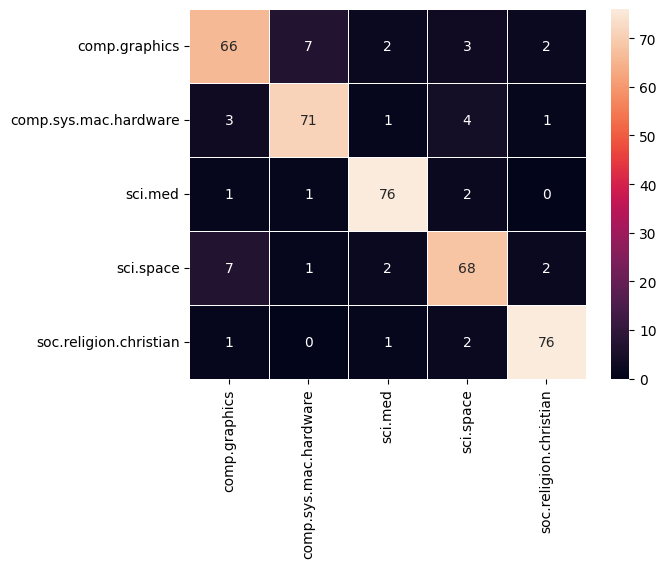

In [35]:

print(classification_report(test['title'],test["predict_ivf"]))
cm2 = confusion_matrix(test['title'],test["predict_ivf"])
labels = ['comp.graphics','comp.sys.mac.hardware','sci.med','sci.space','soc.religion.christian']
sns.heatmap(cm2, fmt='d', annot=True,
     # set all to white
            linewidths=0.5, linecolor='w',  # draw black grid lines
            xticklabels=labels,yticklabels=labels)   

In [36]:
print(classification_report(test['title'],test["predict_ivf"]))
cm2 = confusion_matrix(test['title'],test["predict_ivf"])

                        precision    recall  f1-score   support

         comp.graphics       0.85      0.82      0.84        80
 comp.sys.mac.hardware       0.89      0.89      0.89        80
               sci.med       0.93      0.95      0.94        80
             sci.space       0.86      0.85      0.86        80
soc.religion.christian       0.94      0.95      0.94        80

              accuracy                           0.89       400
             macro avg       0.89      0.89      0.89       400
          weighted avg       0.89      0.89      0.89       400



In [37]:
acc_score = accuracy_score(test['title'],test["predict_ivf"])
print("Test Accuracy Score",acc_score)

Test Accuracy Score 0.8925
